# The Dawid-Skene model with priors

The Dawid-Skene model (1979) is perhaps one of the first models to discover true item states/effects from multiple noisy measurements. Since then, there have been multiple models that improve over the basic model. This notebook covers the Dawid-Skene model which has been enhanced with priors.

The model follows implementation in Rebecca J. Passonneau, Bob Carpenter, "The Benefits of a Model of Annotation", TACL, 2014.

## Introduction
In healthcare, a number of patients can receive potentially noisy judgments from several professionals. In computer science, work items of different difficulty get labeled by multiple annotators of different skill. In this notebook we will attempt to recover true work item labels from noisy annotator input.

The primary goal is to recover the true item states. The secondary goal is to estimate various additional factors of potential interest. We will use probabilistic programming approach in attempt to solve the problem.

In [1]:
%matplotlib inline

import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix

## Data
Load also the data matrix with following dimensions: work items, annotators, categories. The data for this notebook has been taken from https://github.com/abhishekmalali/questioning-strategy-classification/tree/master/data

Note: The data in this notebook is organized in matrix where each work item gets exactly one response for each work item. This is often not possible in practice. The discussed model accepts triplets of data: (work item, annotator, response) which relaxes the constraint to have all observations.

In [2]:
data = np.load(pm.get_data('extrahard_MC_500_5_4.npz.npy'))
z_true = np.load(pm.get_data('extrahard_MC_500_5_4_reference_classes.npy'))

I = data.shape[0]               # number of items
J = data.shape[1]               # number of annotators
K = data.shape[2]               # number of classes
N = I * J

Let's create the necessary data structures. In particular, we will convert the data cube into triplet format. One data point with index n allows to access the following information: jj[n] as annotator ID, providing his/her vote y[n] for item ii[n].

At the same time, we compute the majority vote estimate. This will serve both as a baseline and as initialization for our model.

In [3]:
# create data triplets
jj = list()  # annotator IDs
ii = list()  # item IDs
y = list()   # response

# initialize true category with majority votes
z_init = np.zeros( I, dtype=np.int64 )

# create data triplets
for i in range( I ):
    ks = list()
    for j in range( J ):
        dat = data[ i, j, : ]
        k = np.where( dat == 1 )[0][0]
        ks.append( k )
        ii.append( i )
        jj.append( j )
        y.append( k )

    # getting maj vote for work item i (dealing with numpy casts)
    z_init[ i ] = np.bincount( np.array( ks ) ).argmax()

Comparing true item labels and majority vote estimated labels one by one is tedious. Computing accuracy gives a single performance metric but does not reveal where the mistakes are made (e.g. which categories tend to be confused) and by how much. A confusion matrix with majority vote estimates will serve as our baseline:

In [4]:
confMat = confusion_matrix( z_true, z_init )
print( "Majority vote estimate of true category:\n" , confMat )

Majority vote estimate of true category:
 [[120   2   1   2]
 [  5 116   4   0]
 [  4   6 113   2]
 [  4   3   3 115]]


## Model
With the data loaded and baseline set, we can now start building the Dawid-Skene model. We will start by setting the top level priors: class prevalence and annotator-specific confusion matrices. The two priors are of secondary interest.

The class prevalence prior tells the proportion of categories in the data. Since we are completely ignorant about category proportions, it is meaningful to set a flat distribution.

The annotator-specific confusion matrices will "describe" every annotator. Notably, a confusion matrix for an annotator j tells us which categories the annotator is expert (very high value on diagonal) and where his expertise is limited (relatively small value on diagonal and relatively big values off-diagonal). We will initialize confusion matrices with uniform values with slightly dominant diagonal -- our annotators are expected to provide meaningful labels.

In [5]:
# class prevalence (flat prior)
alpha = np.ones( K )

# individual annotator confusion matrices - dominant diagonal
beta = np.ones( (K,K) ) + np.diag( np.ones(K) )

Now, the interesting part -- the definition of the model.

First, we will need two random variables to encode class prevalence (pi) and annotator confusion matrices (theta). The two random variables can be naturally modeled with Dirichlet.

Second, we will define a variable for the true/hidden category for each work item. The Categorical distribution fits well our purpose to model a work item with K possible states.

Finally, a special variable for observed data brings together all random variables. This is the variable (Categorical) where the data is injected. The parametrization of the variable needs to be explained: the observation y[n] is generated according to Categorical distribution by worker y[n] for item ii[n], where the true label is z[ ii[n] ].

The following block will build the model only but won't do any inference.

In [6]:
model = pm.Model()

with model:
    pi = pm.Dirichlet( 'pi', a=alpha, shape=K )
    theta = pm.Dirichlet( 'theta', a=beta, shape=(J,K,K) )
    z = pm.Categorical( 'z', p=pi, shape=I, testval=z_init )
    y_obs = pm.Categorical( 'y_obs', p=theta[ jj, z[ ii ] ], observed=y )

With model defined, we also need to set up the inference machinery. The variables of interest (pi, theta and z) will be divided in two groups: continuous (pi,theta) and discrete (z). The step methods are different: Metropolis or NUTS for former and CategoricalGibbsMetropolis for latter.

Note: Running the following block will perform inference for our variables of interest and store results in the trace variable. The trace variable will contain a wealth of information that will be useful to perfom diagnostics and get posteriors for our three hidden variables -- class prevalence, annotator confusion matrices and true categories for all work items.

In [7]:
with model:
    step1 = pm.Metropolis( vars=[pi,theta] )
    step2 = pm.CategoricalGibbsMetropolis( vars=[z] )
    trace = pm.sample( 5000, step=[step1, step2], progressbar=True )

100%|██████████| 5000/5000 [28:06<00:00,  4.73it/s]     


## Results

Let's get a global overview of the trace. On the left side of the figure, posterior distributions; on the right - individual samples. The samples subplots should show "uniform band of noise" as the sampler locks around the true variable state. It is important to not see any jumps, switches or steady increase/decrease.

Besides the class prevalence variable ("pi"), the categories and theta posteriors, the plots are of little utility. We will explore other variables in other form.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f245d5c2048>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f2456cb76a0>]], dtype=object)

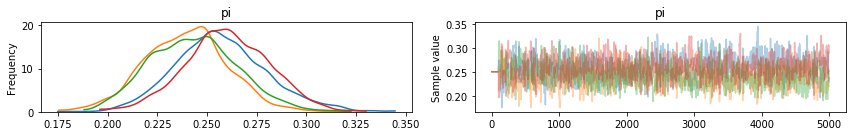

In [8]:
pm.traceplot( trace, varnames=['pi'] )

We will take 1000 last samples from posterior for random variable ("z"). The majority vote from 1000 samples will give us our estimate of true item labels.

In [9]:
z = trace['z'][-1000:,:]

z_hat = np.zeros( I )
for i in range( I ):
    z_hat[ i ] = np.bincount( z[:,i] ).argmax()

The confusion matrix tells us how good our estimate is with respect to the ground truth. Compare it to the baseline: a better estimate has less off diagonal values (and more on main diagonal).

In [10]:
confMat = confusion_matrix( z_true, z_hat )
print( "Dawid-Skene estimate of true category:\n", confMat )

Dawid-Skene estimate of true category:
 [[122   1   1   1]
 [  0 121   1   3]
 [  4   1 115   5]
 [  2   1   1 121]]


Finally, let's plot the confusion matrices of annotators. Notice the dominant diagonal nature of matrices -- measure of annotator performance. Compare the first annotator (j=0) and the last one (j=4).

In [11]:
np.set_printoptions(precision=2)
for j in range( J ):
    print( "Annotator j=" + str(j) )
    Cj = trace['theta'][-1,j]
    print( Cj )

Annotator j=0
[[ 0.89  0.    0.07  0.03]
 [ 0.    0.97  0.03  0.  ]
 [ 0.02  0.01  0.95  0.02]
 [ 0.06  0.02  0.    0.92]]
Annotator j=1
[[ 0.62  0.13  0.09  0.16]
 [ 0.15  0.61  0.09  0.16]
 [ 0.11  0.18  0.66  0.04]
 [ 0.06  0.15  0.1   0.68]]
Annotator j=2
[[ 0.57  0.17  0.15  0.11]
 [ 0.13  0.5   0.25  0.12]
 [ 0.11  0.02  0.68  0.19]
 [ 0.13  0.14  0.12  0.62]]
Annotator j=3
[[ 0.68  0.14  0.1   0.07]
 [ 0.09  0.73  0.08  0.11]
 [ 0.12  0.05  0.74  0.1 ]
 [ 0.07  0.07  0.12  0.73]]
Annotator j=4
[[ 0.56  0.17  0.15  0.12]
 [ 0.14  0.53  0.22  0.11]
 [ 0.12  0.19  0.51  0.18]
 [ 0.22  0.12  0.13  0.53]]
